In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator as IDG
import matplotlib.pyplot as plt
import datetime
from keras import regularizers

In [14]:
images = np.load("/kaggle/input/greyscale-images/greyscale_images_as_numpy_array.npy")
labels = np.loadtxt("/kaggle/input/unibuc-brain-ad/data/train_labels.txt", skiprows=1, usecols=1, delimiter=",", dtype=int)
validation_labels = np.loadtxt("/kaggle/input/unibuc-brain-ad/data/validation_labels.txt", skiprows=1, usecols=1, delimiter=',', dtype=int)

In [15]:

images = tf.image.central_crop(images.reshape(np.shape(images)[0], 224,224,1), 0.85)
print(np.shape(images))

(22149, 192, 192, 1)


In [5]:
# images = tf.image.resize(images, (144,144))
# plt.imshow(images[10])

In [21]:
GLOBAL_BATCH_SIZE = 32
# labels = np.eye(2)[labels].astype(int)
train_dataset =  tf.data.Dataset.from_tensor_slices((images[:15000], labels))
train_dataset = train_dataset.shuffle(15000).batch(GLOBAL_BATCH_SIZE)
print(train_dataset)

validation_dataset =  tf.data.Dataset.from_tensor_slices((images[15000:17000], validation_labels))
validation_dataset = validation_dataset.batch(GLOBAL_BATCH_SIZE)

print(np.shape(images[17000:]))
test_dataset =  tf.data.Dataset.from_tensor_slices(images[17000:])
test_dataset = test_dataset.batch(GLOBAL_BATCH_SIZE)                                           

<BatchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
(5149, 192, 192, 1)


<BatchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [5]:
clasa_0 = np.sum(labels == 0)
clasa_1 = np.sum(labels == 1)
bias_initial = np.log([clasa_0/clasa_1])
print(bias_initial)



[1.7408894]


In [22]:
from sklearn.metrics import f1_score
def f1(labels, predictii):
    predictii = tf.round(predictii)
    return tf.py_function(f1_score, (labels, predictii), tf.float64)
    
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(192, 192, 1)),
#     tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.25),
    tf.keras.layers.Normalization(mean = 0, variance = 1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(192,192,1)),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
#     tf.keras.layers.Dropout(0.15),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
#     tf.keras.layers.Dropout(0.15),
#     tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding = 'same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding = 'same'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.35),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(0.45),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='BinaryCrossentropy',
              metrics=['accuracy', 'Precision', 'Recall', f1])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
checkpoint_path = "training_1/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor= 'val_f1',
                                                 save_best_only = True,
                                                 mode = 'max',
                                                 verbose=1)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 192, 192, 1)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 192, 192, 1)      0         
 tation)                                                         
                                                                 
 random_zoom (RandomZoom)    (None, 192, 192, 1)       0         
                                                                 
 normalization_5 (Normalizat  (None, 192, 192, 1)      0         
 ion)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 192, 192, 32)      320       
                                                                 
 batch_normalization_43 (Bat  (None, 192, 192, 32)    

In [23]:
def lr_schedule(epoch):
    lr = 0.0001
    if epoch >= 10:
        lr *= 0.1
    if epoch >= 35:
        lr *= 0.1
    if epoch >= 80:
        lr *= 0.1
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history = model.fit(train_dataset, validation_data = validation_dataset,
                    epochs=100, callbacks = [callback, cp_callback, lr_scheduler], batch_size = GLOBAL_BATCH_SIZE)

Epoch 1/100


2023-04-09 13:03:33.294256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


363/469 [======================>.......] - ETA: 30s - loss: 0.4669 - accuracy: 0.8394 - precision: 0.3823 - recall: 0.1493 - f1: 0.1798

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.8424 - precision: 0.4320 - recall: 0.1787 - f1: 0.2181
Epoch 1: val_f1 improved from -inf to 0.01323, saving model to training_1/cp.ckpt
469/469 [==============================] - 247s 500ms/step - loss: 0.4437 - accuracy: 0.8424 - precision: 0.4320 - recall: 0.1787 - f1: 0.2181 - val_loss: 0.4216 - val_accuracy: 0.8625 - val_precision: 0.6667 - val_recall: 0.0072 - val_f1: 0.0132 - lr: 1.0000e-04
Epoch 2/100
 95/469 [=====>........................] - ETA: 1:45 - loss: 0.3302 - accuracy: 0.8730 - precision: 0.6272 - recall: 0.2471 - f1: 0.3200

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.8600 - precision: 0.5770 - recall: 0.2310 - f1: 0.2956
Epoch 2: val_f1 improved from 0.01323 to 0.40529, saving model to training_1/cp.ckpt
469/469 [==============================] - 136s 290ms/step - loss: 0.3356 - accuracy: 0.8600 - precision: 0.5770 - recall: 0.2310 - f1: 0.2956 - val_loss: 0.2906 - val_accuracy: 0.8845 - val_precision: 0.6642 - val_recall: 0.3297 - val_f1: 0.4053 - lr: 1.0000e-04
Epoch 3/100
 44/469 [=>............................] - ETA: 1:59 - loss: 0.3346 - accuracy: 0.8530 - precision: 0.5398 - recall: 0.2824 - f1: 0.3415

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


346/469 [=====================>........] - ETA: 34s - loss: 0.3277 - accuracy: 0.8624 - precision: 0.5909 - recall: 0.2877 - f1: 0.3527

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.8657 - precision: 0.5986 - recall: 0.3025 - f1: 0.3658
Epoch 3: val_f1 did not improve from 0.40529
469/469 [==============================] - 135s 287ms/step - loss: 0.3229 - accuracy: 0.8657 - precision: 0.5986 - recall: 0.3025 - f1: 0.3658 - val_loss: 0.3728 - val_accuracy: 0.8475 - val_precision: 0.0606 - val_recall: 0.0072 - val_f1: 0.0085 - lr: 1.0000e-04
Epoch 4/100
469/469 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8776 - precision: 0.6570 - recall: 0.3758 - f1: 0.4456
Epoch 4: val_f1 improved from 0.40529 to 0.44962, saving model to training_1/cp.ckpt
469/469 [==============================] - 135s 289ms/step - loss: 0.3044 - accuracy: 0.8776 - precision: 0.6570 - recall: 0.3758 - f1: 0.4456 - val_loss: 0.4089 - val_accuracy: 0.8035 - val_precision: 0.3725 - val_recall: 0.6196 - val_f1: 0.4496 - lr: 1.0000e-04
Epoch 5/100
 19/469 [>.............................] - ETA: 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8836 - precision: 0.6858 - recall: 0.4057 - f1: 0.4753
Epoch 5: val_f1 did not improve from 0.44962
469/469 [==============================] - 134s 286ms/step - loss: 0.2932 - accuracy: 0.8836 - precision: 0.6858 - recall: 0.4057 - f1: 0.4753 - val_loss: 1.3974 - val_accuracy: 0.5825 - val_precision: 0.2278 - val_recall: 0.8478 - val_f1: 0.3542 - lr: 1.0000e-04
Epoch 6/100
469/469 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.8880 - precision: 0.6927 - recall: 0.4482 - f1: 0.5235
Epoch 6: val_f1 did not improve from 0.44962
469/469 [==============================] - 135s 288ms/step - loss: 0.2807 - accuracy: 0.8880 - precision: 0.6927 - recall: 0.4482 - f1: 0.5235 - val_loss: 0.2987 - val_accuracy: 0.8905 - val_precision: 0.8701 - val_recall: 0.2428 - val_f1: 0.3278 - lr: 1.0000e-04
Epoch 7/100
188/469 [===========>..................] - ETA: 1:19 - loss: 0.2770 - accuracy: 0.8956 -

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.8924 - precision: 0.7182 - recall: 0.4589 - f1: 0.5358
Epoch 7: val_f1 did not improve from 0.44962
469/469 [==============================] - 134s 286ms/step - loss: 0.2770 - accuracy: 0.8924 - precision: 0.7182 - recall: 0.4589 - f1: 0.5358 - val_loss: 0.2905 - val_accuracy: 0.8945 - val_precision: 0.9114 - val_recall: 0.2609 - val_f1: 0.3685 - lr: 1.0000e-04
Epoch 8/100
270/469 [================>.............] - ETA: 56s - loss: 0.2724 - accuracy: 0.8944 - precision: 0.7098 - recall: 0.4938 - f1: 0.5606

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.8947 - precision: 0.7190 - recall: 0.4826 - f1: 0.5555
Epoch 8: val_f1 improved from 0.44962 to 0.50659, saving model to training_1/cp.ckpt
469/469 [==============================] - 136s 290ms/step - loss: 0.2712 - accuracy: 0.8947 - precision: 0.7190 - recall: 0.4826 - f1: 0.5555 - val_loss: 0.2419 - val_accuracy: 0.9030 - val_precision: 0.7808 - val_recall: 0.4130 - val_f1: 0.5066 - lr: 1.0000e-04
Epoch 9/100
469/469 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9005 - precision: 0.7497 - recall: 0.5004 - f1: 0.5803
Epoch 9: val_f1 improved from 0.50659 to 0.54543, saving model to training_1/cp.ckpt
469/469 [==============================] - 136s 290ms/step - loss: 0.2591 - accuracy: 0.9005 - precision: 0.7497 - recall: 0.5004 - f1: 0.5803 - val_loss: 0.3391 - val_accuracy: 0.8575 - val_precision: 0.4881 - val_recall: 0.6667 - val_f1: 0.5454 - lr: 1.0000e-04
Epoch 10/100
469/469

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9161 - precision: 0.8117 - recall: 0.5702 - f1: 0.6466
Epoch 16: val_f1 improved from 0.58959 to 0.59849, saving model to training_1/cp.ckpt
469/469 [==============================] - 136s 290ms/step - loss: 0.2224 - accuracy: 0.9161 - precision: 0.8117 - recall: 0.5702 - f1: 0.6466 - val_loss: 0.2244 - val_accuracy: 0.9130 - val_precision: 0.7684 - val_recall: 0.5290 - val_f1: 0.5985 - lr: 1.0000e-05
Epoch 17/100
469/469 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9149 - precision: 0.8055 - recall: 0.5661 - f1: 0.6411
Epoch 17: val_f1 improved from 0.59849 to 0.60587, saving model to training_1/cp.ckpt
469/469 [==============================] - 136s 290ms/step - loss: 0.2204 - accuracy: 0.9149 - precision: 0.8055 - recall: 0.5661 - f1: 0.6411 - val_loss: 0.2239 - val_accuracy: 0.9100 - val_precision: 0.7222 - val_recall: 0.5652 - val_f1: 0.6059 - lr: 1.0000e-05
Epoch 18/100
187/

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2162 - accuracy: 0.9191 - precision: 0.8274 - recall: 0.5782 - f1: 0.6638
Epoch 18: val_f1 did not improve from 0.60587
469/469 [==============================] - 136s 289ms/step - loss: 0.2162 - accuracy: 0.9191 - precision: 0.8274 - recall: 0.5782 - f1: 0.6638 - val_loss: 0.2346 - val_accuracy: 0.9160 - val_precision: 0.8176 - val_recall: 0.5036 - val_f1: 0.5936 - lr: 1.0000e-05
Epoch 19/100
469/469 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9159 - precision: 0.8109 - recall: 0.5693 - f1: 0.6513
Epoch 19: val_f1 did not improve from 0.60587
469/469 [==============================] - 136s 290ms/step - loss: 0.2186 - accuracy: 0.9159 - precision: 0.8109 - recall: 0.5693 - f1: 0.6513 - val_loss: 0.2248 - val_accuracy: 0.9135 - val_precision: 0.7845 - val_recall: 0.5145 - val_f1: 0.5887 - lr: 1.0000e-05
Epoch 20/100
143/469 [========>.....................] - ETA: 1:32 - loss: 0.2022 - accuracy: 0.92

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


292/469 [=================>............] - ETA: 50s - loss: 0.2092 - accuracy: 0.9196 - precision: 0.8131 - recall: 0.5939 - f1: 0.6632

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9195 - precision: 0.8255 - recall: 0.5836 - f1: 0.6598
Epoch 20: val_f1 did not improve from 0.60587
469/469 [==============================] - 135s 287ms/step - loss: 0.2138 - accuracy: 0.9195 - precision: 0.8255 - recall: 0.5836 - f1: 0.6598 - val_loss: 0.2246 - val_accuracy: 0.9100 - val_precision: 0.7376 - val_recall: 0.5399 - val_f1: 0.5959 - lr: 1.0000e-05
Epoch 21/100
469/469 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9196 - precision: 0.8245 - recall: 0.5858 - f1: 0.6609
Epoch 21: val_f1 did not improve from 0.60587
469/469 [==============================] - 134s 286ms/step - loss: 0.2133 - accuracy: 0.9196 - precision: 0.8245 - recall: 0.5858 - f1: 0.6609 - val_loss: 0.2469 - val_accuracy: 0.9140 - val_precision: 0.9127 - val_recall: 0.4167 - val_f1: 0.5361 - lr: 1.0000e-05
Epoch 22/100
 70/469 [===>..........................] - ETA: 1:52 - loss: 0.2123 - accuracy: 0.91

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


298/469 [==================>...........] - ETA: 48s - loss: 0.2096 - accuracy: 0.9197 - precision: 0.8277 - recall: 0.5836 - f1: 0.6528

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9189 - precision: 0.8247 - recall: 0.5800 - f1: 0.6437
Epoch 22: val_f1 did not improve from 0.60587
469/469 [==============================] - 135s 287ms/step - loss: 0.2108 - accuracy: 0.9189 - precision: 0.8247 - recall: 0.5800 - f1: 0.6437 - val_loss: 0.2273 - val_accuracy: 0.9145 - val_precision: 0.8571 - val_recall: 0.4565 - val_f1: 0.5673 - lr: 1.0000e-05
Epoch 23/100
240/469 [==============>...............] - ETA: 1:05 - loss: 0.2146 - accuracy: 0.9194 - precision: 0.8204 - recall: 0.5936 - f1: 0.6658

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9191 - precision: 0.8258 - recall: 0.5804 - f1: 0.6560
Epoch 23: val_f1 did not improve from 0.60587
469/469 [==============================] - 135s 288ms/step - loss: 0.2127 - accuracy: 0.9191 - precision: 0.8258 - recall: 0.5804 - f1: 0.6560 - val_loss: 0.2361 - val_accuracy: 0.9140 - val_precision: 0.9062 - val_recall: 0.4203 - val_f1: 0.5446 - lr: 1.0000e-05
Epoch 24/100
117/469 [======>.......................] - ETA: 1:40 - loss: 0.2230 - accuracy: 0.9143 - precision: 0.8214 - recall: 0.5620 - f1: 0.6346

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.9195 - precision: 0.8269 - recall: 0.5827 - f1: 0.6567
Epoch 24: val_f1 improved from 0.60587 to 0.61096, saving model to training_1/cp.ckpt
469/469 [==============================] - 135s 289ms/step - loss: 0.2109 - accuracy: 0.9195 - precision: 0.8269 - recall: 0.5827 - f1: 0.6567 - val_loss: 0.2282 - val_accuracy: 0.9105 - val_precision: 0.7118 - val_recall: 0.5906 - val_f1: 0.6110 - lr: 1.0000e-05
Epoch 25/100
469/469 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9195 - precision: 0.8187 - recall: 0.5912 - f1: 0.6656
Epoch 25: val_f1 did not improve from 0.61096
469/469 [==============================] - 134s 286ms/step - loss: 0.2078 - accuracy: 0.9195 - precision: 0.8187 - recall: 0.5912 - f1: 0.6656 - val_loss: 0.2343 - val_accuracy: 0.9100 - val_precision: 0.7697 - val_recall: 0.4964 - val_f1: 0.5723 - lr: 1.0000e-05
Epoch 26/100
469/469 [==============================] - E

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


458/469 [============================>.] - ETA: 3s - loss: 0.2068 - accuracy: 0.9194 - precision: 0.8214 - recall: 0.5869 - f1: 0.6567

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9190 - precision: 0.8211 - recall: 0.5845 - f1: 0.6553
Epoch 27: val_f1 did not improve from 0.61096
469/469 [==============================] - 134s 286ms/step - loss: 0.2081 - accuracy: 0.9190 - precision: 0.8211 - recall: 0.5845 - f1: 0.6553 - val_loss: 0.2144 - val_accuracy: 0.9205 - val_precision: 0.8679 - val_recall: 0.5000 - val_f1: 0.6047 - lr: 1.0000e-05
Epoch 28/100
 31/469 [>.............................] - ETA: 2:01 - loss: 0.1935 - accuracy: 0.9254 - precision: 0.8442 - recall: 0.5118 - f1: 0.5776

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9211 - precision: 0.8328 - recall: 0.5898 - f1: 0.6611
Epoch 28: val_f1 did not improve from 0.61096
469/469 [==============================] - 135s 287ms/step - loss: 0.2038 - accuracy: 0.9211 - precision: 0.8328 - recall: 0.5898 - f1: 0.6611 - val_loss: 0.2188 - val_accuracy: 0.9170 - val_precision: 0.8395 - val_recall: 0.4928 - val_f1: 0.5929 - lr: 1.0000e-05
Epoch 29/100
195/469 [===========>..................] - ETA: 1:17 - loss: 0.1978 - accuracy: 0.9242 - precision: 0.8306 - recall: 0.6089 - f1: 0.6869

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9209 - precision: 0.8267 - recall: 0.5947 - f1: 0.6746
Epoch 29: val_f1 improved from 0.61096 to 0.61743, saving model to training_1/cp.ckpt
469/469 [==============================] - 136s 290ms/step - loss: 0.2040 - accuracy: 0.9209 - precision: 0.8267 - recall: 0.5947 - f1: 0.6746 - val_loss: 0.2187 - val_accuracy: 0.9160 - val_precision: 0.7755 - val_recall: 0.5507 - val_f1: 0.6174 - lr: 1.0000e-05
Epoch 30/100
469/469 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9197 - precision: 0.8243 - recall: 0.5871 - f1: 0.6637
Epoch 30: val_f1 did not improve from 0.61743
469/469 [==============================] - 135s 289ms/step - loss: 0.2052 - accuracy: 0.9197 - precision: 0.8243 - recall: 0.5871 - f1: 0.6637 - val_loss: 0.2232 - val_accuracy: 0.9160 - val_precision: 0.7812 - val_recall: 0.5435 - val_f1: 0.6069 - lr: 1.0000e-05
Epoch 31/100
469/469 [==============================] - E

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


158/469 [=========>....................] - ETA: 1:28 - loss: 0.2051 - accuracy: 0.9205 - precision: 0.8290 - recall: 0.5934 - f1: 0.6584

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


401/469 [========================>.....] - ETA: 19s - loss: 0.2038 - accuracy: 0.9212 - precision: 0.8304 - recall: 0.5905 - f1: 0.6543

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9216 - precision: 0.8298 - recall: 0.5970 - f1: 0.6617
Epoch 32: val_f1 improved from 0.61835 to 0.62213, saving model to training_1/cp.ckpt
469/469 [==============================] - 137s 291ms/step - loss: 0.2026 - accuracy: 0.9216 - precision: 0.8298 - recall: 0.5970 - f1: 0.6617 - val_loss: 0.2264 - val_accuracy: 0.9145 - val_precision: 0.7512 - val_recall: 0.5688 - val_f1: 0.6221 - lr: 1.0000e-05
Epoch 33/100
469/469 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9239 - precision: 0.8383 - recall: 0.6068 - f1: 0.6811
Epoch 33: val_f1 did not improve from 0.62213
469/469 [==============================] - 136s 289ms/step - loss: 0.1992 - accuracy: 0.9239 - precision: 0.8383 - recall: 0.6068 - f1: 0.6811 - val_loss: 0.2184 - val_accuracy: 0.9165 - val_precision: 0.7978 - val_recall: 0.5290 - val_f1: 0.6016 - lr: 1.0000e-05
Epoch 34/100
469/469 [==============================] - E

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9252 - precision: 0.8357 - recall: 0.6206 - f1: 0.6900
Epoch 35: val_f1 did not improve from 0.62213
469/469 [==============================] - 135s 289ms/step - loss: 0.1978 - accuracy: 0.9252 - precision: 0.8357 - recall: 0.6206 - f1: 0.6900 - val_loss: 0.2169 - val_accuracy: 0.9215 - val_precision: 0.8563 - val_recall: 0.5181 - val_f1: 0.6189 - lr: 1.0000e-05
Epoch 36/100
469/469 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9244 - precision: 0.8290 - recall: 0.6215 - f1: 0.6784
Epoch 36: val_f1 did not improve from 0.62213
469/469 [==============================] - 135s 288ms/step - loss: 0.1955 - accuracy: 0.9244 - precision: 0.8290 - recall: 0.6215 - f1: 0.6784 - val_loss: 0.2101 - val_accuracy: 0.9205 - val_precision: 0.8634 - val_recall: 0.5036 - val_f1: 0.5991 - lr: 1.0000e-06
Epoch 37/100
469/469 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9270

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9285 - precision: 0.8589 - recall: 0.6229 - f1: 0.6930
Epoch 43: val_f1 improved from 0.62914 to 0.63954, saving model to training_1/cp.ckpt
469/469 [==============================] - 135s 288ms/step - loss: 0.1876 - accuracy: 0.9285 - precision: 0.8589 - recall: 0.6229 - f1: 0.6930 - val_loss: 0.2120 - val_accuracy: 0.9215 - val_precision: 0.8051 - val_recall: 0.5688 - val_f1: 0.6395 - lr: 1.0000e-06
Epoch 44/100
469/469 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9267 - precision: 0.8327 - recall: 0.6363 - f1: 0.6981
Epoch 44: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1896 - accuracy: 0.9267 - precision: 0.8327 - recall: 0.6363 - f1: 0.6981 - val_loss: 0.2120 - val_accuracy: 0.9225 - val_precision: 0.8380 - val_recall: 0.5435 - val_f1: 0.6266 - lr: 1.0000e-06
Epoch 45/100
469/469 [==============================] - E

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9264 - precision: 0.8355 - recall: 0.6309 - f1: 0.6985
Epoch 46: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 289ms/step - loss: 0.1868 - accuracy: 0.9264 - precision: 0.8355 - recall: 0.6309 - f1: 0.6985 - val_loss: 0.2118 - val_accuracy: 0.9220 - val_precision: 0.8261 - val_recall: 0.5507 - val_f1: 0.6314 - lr: 1.0000e-06
Epoch 47/100
366/469 [======================>.......] - ETA: 29s - loss: 0.1923 - accuracy: 0.9255 - precision: 0.8368 - recall: 0.6261 - f1: 0.6900

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9266 - precision: 0.8394 - recall: 0.6282 - f1: 0.6903
Epoch 47: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1899 - accuracy: 0.9266 - precision: 0.8394 - recall: 0.6282 - f1: 0.6903 - val_loss: 0.2124 - val_accuracy: 0.9230 - val_precision: 0.8506 - val_recall: 0.5362 - val_f1: 0.6286 - lr: 1.0000e-06
Epoch 48/100
368/469 [======================>.......] - ETA: 28s - loss: 0.1842 - accuracy: 0.9281 - precision: 0.8441 - recall: 0.6350 - f1: 0.7018

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9275 - precision: 0.8423 - recall: 0.6323 - f1: 0.7005
Epoch 48: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1854 - accuracy: 0.9275 - precision: 0.8423 - recall: 0.6323 - f1: 0.7005 - val_loss: 0.2121 - val_accuracy: 0.9215 - val_precision: 0.8362 - val_recall: 0.5362 - val_f1: 0.6217 - lr: 1.0000e-06
Epoch 49/100
325/469 [===================>..........] - ETA: 41s - loss: 0.1934 - accuracy: 0.9245 - precision: 0.8327 - recall: 0.6155 - f1: 0.6856

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9266 - precision: 0.8419 - recall: 0.6256 - f1: 0.6906
Epoch 49: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 289ms/step - loss: 0.1878 - accuracy: 0.9266 - precision: 0.8419 - recall: 0.6256 - f1: 0.6906 - val_loss: 0.2122 - val_accuracy: 0.9190 - val_precision: 0.8000 - val_recall: 0.5507 - val_f1: 0.6256 - lr: 1.0000e-06
Epoch 50/100
469/469 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9281 - precision: 0.8423 - recall: 0.6372 - f1: 0.6998
Epoch 50: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1876 - accuracy: 0.9281 - precision: 0.8423 - recall: 0.6372 - f1: 0.6998 - val_loss: 0.2110 - val_accuracy: 0.9205 - val_precision: 0.8197 - val_recall: 0.5435 - val_f1: 0.6247 - lr: 1.0000e-06
Epoch 51/100
166/469 [=========>....................] - ETA: 1:26 - loss: 0.1880 - accuracy: 0.92

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


234/469 [=============>................] - ETA: 1:06 - loss: 0.1935 - accuracy: 0.9243 - precision: 0.8461 - recall: 0.6181 - f1: 0.6764

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9254 - precision: 0.8373 - recall: 0.6206 - f1: 0.6848
Epoch 51: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1913 - accuracy: 0.9254 - precision: 0.8373 - recall: 0.6206 - f1: 0.6848 - val_loss: 0.2125 - val_accuracy: 0.9220 - val_precision: 0.8297 - val_recall: 0.5471 - val_f1: 0.6340 - lr: 1.0000e-06
Epoch 52/100
255/469 [===============>..............] - ETA: 1:00 - loss: 0.1914 - accuracy: 0.9262 - precision: 0.8512 - recall: 0.6254 - f1: 0.6984

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9285 - precision: 0.8453 - recall: 0.6372 - f1: 0.7051
Epoch 52: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 289ms/step - loss: 0.1874 - accuracy: 0.9285 - precision: 0.8453 - recall: 0.6372 - f1: 0.7051 - val_loss: 0.2144 - val_accuracy: 0.9215 - val_precision: 0.8400 - val_recall: 0.5326 - val_f1: 0.6184 - lr: 1.0000e-06
Epoch 53/100
158/469 [=========>....................] - ETA: 1:28 - loss: 0.1736 - accuracy: 0.9337 - precision: 0.8604 - recall: 0.6555 - f1: 0.7014

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


186/469 [==========>...................] - ETA: 1:20 - loss: 0.1729 - accuracy: 0.9345 - precision: 0.8574 - recall: 0.6498 - f1: 0.6946

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9302 - precision: 0.8530 - recall: 0.6430 - f1: 0.7020
Epoch 53: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1831 - accuracy: 0.9302 - precision: 0.8530 - recall: 0.6430 - f1: 0.7020 - val_loss: 0.2145 - val_accuracy: 0.9210 - val_precision: 0.8242 - val_recall: 0.5435 - val_f1: 0.6233 - lr: 1.0000e-06
Epoch 54/100
 14/469 [..............................] - ETA: 2:09 - loss: 0.1789 - accuracy: 0.9286 - precision: 0.8182 - recall: 0.6000 - f1: 0.6512

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9287 - precision: 0.8527 - recall: 0.6314 - f1: 0.7018
Epoch 54: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1845 - accuracy: 0.9287 - precision: 0.8527 - recall: 0.6314 - f1: 0.7018 - val_loss: 0.2139 - val_accuracy: 0.9190 - val_precision: 0.7938 - val_recall: 0.5580 - val_f1: 0.6288 - lr: 1.0000e-06
Epoch 55/100
469/469 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9296 - precision: 0.8428 - recall: 0.6492 - f1: 0.6950
Epoch 55: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1850 - accuracy: 0.9296 - precision: 0.8428 - recall: 0.6492 - f1: 0.6950 - val_loss: 0.2137 - val_accuracy: 0.9220 - val_precision: 0.8226 - val_recall: 0.5543 - val_f1: 0.6372 - lr: 1.0000e-06
Epoch 56/100
311/469 [==================>...........] - ETA: 44s - loss: 0.1918 - accuracy: 0.926

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


406/469 [========================>.....] - ETA: 17s - loss: 0.1876 - accuracy: 0.9282 - precision: 0.8377 - recall: 0.6400 - f1: 0.6999

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9277 - precision: 0.8414 - recall: 0.6354 - f1: 0.6947
Epoch 56: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1872 - accuracy: 0.9277 - precision: 0.8414 - recall: 0.6354 - f1: 0.6947 - val_loss: 0.2125 - val_accuracy: 0.9215 - val_precision: 0.8324 - val_recall: 0.5399 - val_f1: 0.6264 - lr: 1.0000e-06
Epoch 57/100
234/469 [=============>................] - ETA: 1:06 - loss: 0.1864 - accuracy: 0.9298 - precision: 0.8444 - recall: 0.6497 - f1: 0.7089

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


390/469 [=======================>......] - ETA: 22s - loss: 0.1822 - accuracy: 0.9304 - precision: 0.8468 - recall: 0.6450 - f1: 0.7023

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9286 - precision: 0.8418 - recall: 0.6421 - f1: 0.7020
Epoch 57: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1839 - accuracy: 0.9286 - precision: 0.8418 - recall: 0.6421 - f1: 0.7020 - val_loss: 0.2129 - val_accuracy: 0.9215 - val_precision: 0.8251 - val_recall: 0.5471 - val_f1: 0.6303 - lr: 1.0000e-06
Epoch 58/100
469/469 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9293 - precision: 0.8456 - recall: 0.6434 - f1: 0.7034
Epoch 58: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1856 - accuracy: 0.9293 - precision: 0.8456 - recall: 0.6434 - f1: 0.7034 - val_loss: 0.2125 - val_accuracy: 0.9220 - val_precision: 0.8333 - val_recall: 0.5435 - val_f1: 0.6321 - lr: 1.0000e-06
Epoch 59/100
469/469 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9271

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


415/469 [=========================>....] - ETA: 15s - loss: 0.1871 - accuracy: 0.9282 - precision: 0.8406 - recall: 0.6406 - f1: 0.7041

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9289 - precision: 0.8472 - recall: 0.6390 - f1: 0.7064
Epoch 61: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1855 - accuracy: 0.9289 - precision: 0.8472 - recall: 0.6390 - f1: 0.7064 - val_loss: 0.2160 - val_accuracy: 0.9205 - val_precision: 0.8197 - val_recall: 0.5435 - val_f1: 0.6206 - lr: 1.0000e-06
Epoch 62/100
333/469 [====================>.........] - ETA: 38s - loss: 0.1889 - accuracy: 0.9268 - precision: 0.8463 - recall: 0.6296 - f1: 0.6999

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


384/469 [=======================>......] - ETA: 24s - loss: 0.1879 - accuracy: 0.9273 - precision: 0.8398 - recall: 0.6314 - f1: 0.6942

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9285 - precision: 0.8454 - recall: 0.6376 - f1: 0.7021
Epoch 62: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1862 - accuracy: 0.9285 - precision: 0.8454 - recall: 0.6376 - f1: 0.7021 - val_loss: 0.2122 - val_accuracy: 0.9195 - val_precision: 0.7949 - val_recall: 0.5616 - val_f1: 0.6318 - lr: 1.0000e-06
Epoch 63/100
 23/469 [>.............................] - ETA: 2:04 - loss: 0.1891 - accuracy: 0.9280 - precision: 0.8763 - recall: 0.6746 - f1: 0.7162

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9309 - precision: 0.8569 - recall: 0.6448 - f1: 0.7125
Epoch 63: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1820 - accuracy: 0.9309 - precision: 0.8569 - recall: 0.6448 - f1: 0.7125 - val_loss: 0.2118 - val_accuracy: 0.9205 - val_precision: 0.8197 - val_recall: 0.5435 - val_f1: 0.6241 - lr: 1.0000e-06
Epoch 64/100
 35/469 [=>............................] - ETA: 2:07 - loss: 0.1744 - accuracy: 0.9277 - precision: 0.7982 - recall: 0.6107 - f1: 0.6479

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


339/469 [====================>.........] - ETA: 37s - loss: 0.1809 - accuracy: 0.9310 - precision: 0.8536 - recall: 0.6438 - f1: 0.6951

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


418/469 [=========================>....] - ETA: 14s - loss: 0.1824 - accuracy: 0.9302 - precision: 0.8530 - recall: 0.6471 - f1: 0.6980

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9296 - precision: 0.8472 - recall: 0.6443 - f1: 0.6938
Epoch 64: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 290ms/step - loss: 0.1832 - accuracy: 0.9296 - precision: 0.8472 - recall: 0.6443 - f1: 0.6938 - val_loss: 0.2149 - val_accuracy: 0.9200 - val_precision: 0.8152 - val_recall: 0.5435 - val_f1: 0.6257 - lr: 1.0000e-06
Epoch 65/100
469/469 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9298 - precision: 0.8487 - recall: 0.6443 - f1: 0.7082
Epoch 65: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1812 - accuracy: 0.9298 - precision: 0.8487 - recall: 0.6443 - f1: 0.7082 - val_loss: 0.2154 - val_accuracy: 0.9210 - val_precision: 0.8010 - val_recall: 0.5688 - val_f1: 0.6391 - lr: 1.0000e-06
Epoch 66/100
 75/469 [===>..........................] - ETA: 1:51 - loss: 0.1782 - accuracy: 0.93

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


414/469 [=========================>....] - ETA: 15s - loss: 0.1838 - accuracy: 0.9306 - precision: 0.8523 - recall: 0.6473 - f1: 0.7069

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


462/469 [============================>.] - ETA: 1s - loss: 0.1839 - accuracy: 0.9299 - precision: 0.8476 - recall: 0.6445 - f1: 0.7032

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9297 - precision: 0.8491 - recall: 0.6434 - f1: 0.7033
Epoch 66: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 289ms/step - loss: 0.1837 - accuracy: 0.9297 - precision: 0.8491 - recall: 0.6434 - f1: 0.7033 - val_loss: 0.2146 - val_accuracy: 0.9195 - val_precision: 0.8249 - val_recall: 0.5290 - val_f1: 0.6186 - lr: 1.0000e-06
Epoch 67/100
254/469 [===============>..............] - ETA: 1:01 - loss: 0.1807 - accuracy: 0.9306 - precision: 0.8555 - recall: 0.6372 - f1: 0.7011

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


368/469 [======================>.......] - ETA: 28s - loss: 0.1778 - accuracy: 0.9309 - precision: 0.8509 - recall: 0.6410 - f1: 0.7083

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9289 - precision: 0.8475 - recall: 0.6381 - f1: 0.7076
Epoch 67: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 289ms/step - loss: 0.1823 - accuracy: 0.9289 - precision: 0.8475 - recall: 0.6381 - f1: 0.7076 - val_loss: 0.2184 - val_accuracy: 0.9195 - val_precision: 0.7919 - val_recall: 0.5652 - val_f1: 0.6310 - lr: 1.0000e-06
Epoch 68/100
469/469 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9298 - precision: 0.8508 - recall: 0.6421 - f1: 0.7025
Epoch 68: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1862 - accuracy: 0.9298 - precision: 0.8508 - recall: 0.6421 - f1: 0.7025 - val_loss: 0.2171 - val_accuracy: 0.9210 - val_precision: 0.8138 - val_recall: 0.5543 - val_f1: 0.6327 - lr: 1.0000e-06
Epoch 69/100
469/469 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9319

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


249/469 [==============>...............] - ETA: 1:03 - loss: 0.1731 - accuracy: 0.9331 - precision: 0.8441 - recall: 0.6429 - f1: 0.6960

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9301 - precision: 0.8512 - recall: 0.6443 - f1: 0.7068
Epoch 70: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1816 - accuracy: 0.9301 - precision: 0.8512 - recall: 0.6443 - f1: 0.7068 - val_loss: 0.2154 - val_accuracy: 0.9195 - val_precision: 0.8108 - val_recall: 0.5435 - val_f1: 0.6201 - lr: 1.0000e-06
Epoch 71/100
469/469 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9290 - precision: 0.8448 - recall: 0.6421 - f1: 0.7011
Epoch 71: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1831 - accuracy: 0.9290 - precision: 0.8448 - recall: 0.6421 - f1: 0.7011 - val_loss: 0.2174 - val_accuracy: 0.9200 - val_precision: 0.8372 - val_recall: 0.5217 - val_f1: 0.6124 - lr: 1.0000e-06
Epoch 72/100
469/469 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9290

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9291 - precision: 0.8409 - recall: 0.6470 - f1: 0.7010
Epoch 73: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 289ms/step - loss: 0.1841 - accuracy: 0.9291 - precision: 0.8409 - recall: 0.6470 - f1: 0.7010 - val_loss: 0.2126 - val_accuracy: 0.9210 - val_precision: 0.8207 - val_recall: 0.5471 - val_f1: 0.6296 - lr: 1.0000e-06
Epoch 74/100
 96/469 [=====>........................] - ETA: 1:46 - loss: 0.1933 - accuracy: 0.9294 - precision: 0.8179 - recall: 0.6265 - f1: 0.6914

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9297 - precision: 0.8453 - recall: 0.6470 - f1: 0.7120
Epoch 74: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1836 - accuracy: 0.9297 - precision: 0.8453 - recall: 0.6470 - f1: 0.7120 - val_loss: 0.2131 - val_accuracy: 0.9190 - val_precision: 0.7908 - val_recall: 0.5616 - val_f1: 0.6305 - lr: 1.0000e-06
Epoch 75/100
 49/469 [==>...........................] - ETA: 2:00 - loss: 0.1906 - accuracy: 0.9235 - precision: 0.8402 - recall: 0.6468 - f1: 0.7028

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


206/469 [============>.................] - ETA: 1:14 - loss: 0.1834 - accuracy: 0.9313 - precision: 0.8617 - recall: 0.6527 - f1: 0.7194

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9307 - precision: 0.8520 - recall: 0.6483 - f1: 0.7107
Epoch 75: val_f1 did not improve from 0.63954
469/469 [==============================] - 134s 286ms/step - loss: 0.1816 - accuracy: 0.9307 - precision: 0.8520 - recall: 0.6483 - f1: 0.7107 - val_loss: 0.2115 - val_accuracy: 0.9200 - val_precision: 0.8053 - val_recall: 0.5543 - val_f1: 0.6331 - lr: 1.0000e-06
Epoch 76/100
291/469 [=================>............] - ETA: 50s - loss: 0.1800 - accuracy: 0.9306 - precision: 0.8417 - recall: 0.6458 - f1: 0.6908

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


336/469 [====================>.........] - ETA: 37s - loss: 0.1802 - accuracy: 0.9306 - precision: 0.8474 - recall: 0.6434 - f1: 0.6906

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9294 - precision: 0.8449 - recall: 0.6452 - f1: 0.6937
Epoch 76: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1817 - accuracy: 0.9294 - precision: 0.8449 - recall: 0.6452 - f1: 0.6937 - val_loss: 0.2117 - val_accuracy: 0.9195 - val_precision: 0.8042 - val_recall: 0.5507 - val_f1: 0.6284 - lr: 1.0000e-06
Epoch 77/100
123/469 [======>.......................] - ETA: 1:38 - loss: 0.1787 - accuracy: 0.9301 - precision: 0.8356 - recall: 0.6432 - f1: 0.6823

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9301 - precision: 0.8483 - recall: 0.6470 - f1: 0.7051
Epoch 77: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1832 - accuracy: 0.9301 - precision: 0.8483 - recall: 0.6470 - f1: 0.7051 - val_loss: 0.2137 - val_accuracy: 0.9205 - val_precision: 0.8305 - val_recall: 0.5326 - val_f1: 0.6210 - lr: 1.0000e-06
Epoch 78/100
 32/469 [=>............................] - ETA: 2:07 - loss: 0.1796 - accuracy: 0.9297 - precision: 0.8120 - recall: 0.6552 - f1: 0.7071

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


166/469 [=========>....................] - ETA: 1:26 - loss: 0.1707 - accuracy: 0.9339 - precision: 0.8485 - recall: 0.6521 - f1: 0.7076

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9312 - precision: 0.8555 - recall: 0.6483 - f1: 0.7112
Epoch 78: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1802 - accuracy: 0.9312 - precision: 0.8555 - recall: 0.6483 - f1: 0.7112 - val_loss: 0.2138 - val_accuracy: 0.9195 - val_precision: 0.7949 - val_recall: 0.5616 - val_f1: 0.6335 - lr: 1.0000e-06
Epoch 79/100
429/469 [==========================>...] - ETA: 11s - loss: 0.1831 - accuracy: 0.9294 - precision: 0.8381 - recall: 0.6527 - f1: 0.7021

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


456/469 [============================>.] - ETA: 3s - loss: 0.1825 - accuracy: 0.9297 - precision: 0.8401 - recall: 0.6535 - f1: 0.7027

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9294 - precision: 0.8402 - recall: 0.6506 - f1: 0.6998
Epoch 79: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1839 - accuracy: 0.9294 - precision: 0.8402 - recall: 0.6506 - f1: 0.6998 - val_loss: 0.2142 - val_accuracy: 0.9205 - val_precision: 0.8462 - val_recall: 0.5181 - val_f1: 0.6108 - lr: 1.0000e-06
Epoch 80/100
 47/469 [==>...........................] - ETA: 2:01 - loss: 0.1733 - accuracy: 0.9249 - precision: 0.8013 - recall: 0.6039 - f1: 0.6493

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


304/469 [==================>...........] - ETA: 46s - loss: 0.1860 - accuracy: 0.9256 - precision: 0.8373 - recall: 0.6282 - f1: 0.6864

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9287 - precision: 0.8439 - recall: 0.6403 - f1: 0.7023
Epoch 80: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1812 - accuracy: 0.9287 - precision: 0.8439 - recall: 0.6403 - f1: 0.7023 - val_loss: 0.2148 - val_accuracy: 0.9200 - val_precision: 0.8333 - val_recall: 0.5254 - val_f1: 0.6175 - lr: 1.0000e-06
Epoch 81/100
384/469 [=======================>......] - ETA: 24s - loss: 0.1806 - accuracy: 0.9312 - precision: 0.8557 - recall: 0.6432 - f1: 0.7078

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9307 - precision: 0.8520 - recall: 0.6483 - f1: 0.7098
Epoch 81: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1802 - accuracy: 0.9307 - precision: 0.8520 - recall: 0.6483 - f1: 0.7098 - val_loss: 0.2131 - val_accuracy: 0.9210 - val_precision: 0.8315 - val_recall: 0.5362 - val_f1: 0.6259 - lr: 1.0000e-07
Epoch 82/100
 92/469 [====>.........................] - ETA: 1:46 - loss: 0.1755 - accuracy: 0.9273 - precision: 0.8413 - recall: 0.6357 - f1: 0.6941

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


174/469 [==========>...................] - ETA: 1:23 - loss: 0.1747 - accuracy: 0.9312 - precision: 0.8510 - recall: 0.6501 - f1: 0.7083

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


298/469 [==================>...........] - ETA: 48s - loss: 0.1788 - accuracy: 0.9303 - precision: 0.8519 - recall: 0.6549 - f1: 0.7137

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9289 - precision: 0.8395 - recall: 0.6475 - f1: 0.7031
Epoch 82: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1812 - accuracy: 0.9289 - precision: 0.8395 - recall: 0.6475 - f1: 0.7031 - val_loss: 0.2136 - val_accuracy: 0.9215 - val_precision: 0.8362 - val_recall: 0.5362 - val_f1: 0.6268 - lr: 1.0000e-07
Epoch 83/100
369/469 [======================>.......] - ETA: 28s - loss: 0.1812 - accuracy: 0.9290 - precision: 0.8521 - recall: 0.6467 - f1: 0.7120

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9299 - precision: 0.8481 - recall: 0.6461 - f1: 0.7113
Epoch 83: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 290ms/step - loss: 0.1815 - accuracy: 0.9299 - precision: 0.8481 - recall: 0.6461 - f1: 0.7113 - val_loss: 0.2128 - val_accuracy: 0.9205 - val_precision: 0.8268 - val_recall: 0.5362 - val_f1: 0.6244 - lr: 1.0000e-07
Epoch 84/100
 25/469 [>.............................] - ETA: 2:05 - loss: 0.1915 - accuracy: 0.9237 - precision: 0.8161 - recall: 0.6121 - f1: 0.6316

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


124/469 [======>.......................] - ETA: 1:37 - loss: 0.1797 - accuracy: 0.9320 - precision: 0.8462 - recall: 0.6581 - f1: 0.7053

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


185/469 [==========>...................] - ETA: 1:20 - loss: 0.1771 - accuracy: 0.9323 - precision: 0.8444 - recall: 0.6582 - f1: 0.7030

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9308 - precision: 0.8488 - recall: 0.6524 - f1: 0.7083
Epoch 84: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1791 - accuracy: 0.9308 - precision: 0.8488 - recall: 0.6524 - f1: 0.7083 - val_loss: 0.2123 - val_accuracy: 0.9215 - val_precision: 0.8324 - val_recall: 0.5399 - val_f1: 0.6284 - lr: 1.0000e-07
Epoch 85/100
289/469 [=================>............] - ETA: 50s - loss: 0.1815 - accuracy: 0.9290 - precision: 0.8388 - recall: 0.6503 - f1: 0.6939

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


393/469 [========================>.....] - ETA: 21s - loss: 0.1797 - accuracy: 0.9299 - precision: 0.8352 - recall: 0.6532 - f1: 0.6971

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9299 - precision: 0.8385 - recall: 0.6564 - f1: 0.7030
Epoch 85: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1821 - accuracy: 0.9299 - precision: 0.8385 - recall: 0.6564 - f1: 0.7030 - val_loss: 0.2128 - val_accuracy: 0.9205 - val_precision: 0.8305 - val_recall: 0.5326 - val_f1: 0.6217 - lr: 1.0000e-07
Epoch 86/100
469/469 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9293 - precision: 0.8413 - recall: 0.6488 - f1: 0.7085
Epoch 86: val_f1 did not improve from 0.63954
469/469 [==============================] - 134s 287ms/step - loss: 0.1819 - accuracy: 0.9293 - precision: 0.8413 - recall: 0.6488 - f1: 0.7085 - val_loss: 0.2128 - val_accuracy: 0.9205 - val_precision: 0.8232 - val_recall: 0.5399 - val_f1: 0.6254 - lr: 1.0000e-07
Epoch 87/100
469/469 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9287

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9289 - precision: 0.8367 - recall: 0.6501 - f1: 0.7063
Epoch 88: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1823 - accuracy: 0.9289 - precision: 0.8367 - recall: 0.6501 - f1: 0.7063 - val_loss: 0.2127 - val_accuracy: 0.9205 - val_precision: 0.8232 - val_recall: 0.5399 - val_f1: 0.6254 - lr: 1.0000e-07
Epoch 89/100
297/469 [=================>............] - ETA: 48s - loss: 0.1860 - accuracy: 0.9277 - precision: 0.8362 - recall: 0.6338 - f1: 0.6944

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


445/469 [===========================>..] - ETA: 6s - loss: 0.1834 - accuracy: 0.9287 - precision: 0.8453 - recall: 0.6385 - f1: 0.7019

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9289 - precision: 0.8454 - recall: 0.6403 - f1: 0.7039
Epoch 89: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1833 - accuracy: 0.9289 - precision: 0.8454 - recall: 0.6403 - f1: 0.7039 - val_loss: 0.2123 - val_accuracy: 0.9205 - val_precision: 0.8197 - val_recall: 0.5435 - val_f1: 0.6277 - lr: 1.0000e-07
Epoch 90/100
202/469 [===========>..................] - ETA: 1:15 - loss: 0.1830 - accuracy: 0.9312 - precision: 0.8560 - recall: 0.6473 - f1: 0.7149

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9300 - precision: 0.8470 - recall: 0.6479 - f1: 0.7075
Epoch 90: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1820 - accuracy: 0.9300 - precision: 0.8470 - recall: 0.6479 - f1: 0.7075 - val_loss: 0.2117 - val_accuracy: 0.9220 - val_precision: 0.8297 - val_recall: 0.5471 - val_f1: 0.6342 - lr: 1.0000e-07
Epoch 91/100
469/469 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9306 - precision: 0.8514 - recall: 0.6479 - f1: 0.7061
Epoch 91: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 289ms/step - loss: 0.1809 - accuracy: 0.9306 - precision: 0.8514 - recall: 0.6479 - f1: 0.7061 - val_loss: 0.2122 - val_accuracy: 0.9200 - val_precision: 0.8222 - val_recall: 0.5362 - val_f1: 0.6229 - lr: 1.0000e-07
Epoch 92/100
469/469 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9295

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9299 - precision: 0.8440 - recall: 0.6501 - f1: 0.6980
Epoch 93: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1778 - accuracy: 0.9299 - precision: 0.8440 - recall: 0.6501 - f1: 0.6980 - val_loss: 0.2127 - val_accuracy: 0.9210 - val_precision: 0.8315 - val_recall: 0.5362 - val_f1: 0.6254 - lr: 1.0000e-07
Epoch 94/100
  4/469 [..............................] - ETA: 2:09 - loss: 0.1158 - accuracy: 0.9531 - precision: 0.8125 - recall: 0.8125 - f1: 0.6145

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9321 - precision: 0.8571 - recall: 0.6542 - f1: 0.7106
Epoch 94: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 287ms/step - loss: 0.1810 - accuracy: 0.9321 - precision: 0.8571 - recall: 0.6542 - f1: 0.7106 - val_loss: 0.2125 - val_accuracy: 0.9205 - val_precision: 0.8197 - val_recall: 0.5435 - val_f1: 0.6277 - lr: 1.0000e-07
Epoch 95/100
 98/469 [=====>........................] - ETA: 1:45 - loss: 0.1803 - accuracy: 0.9289 - precision: 0.8668 - recall: 0.6471 - f1: 0.7139

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


156/469 [========>.....................] - ETA: 1:29 - loss: 0.1785 - accuracy: 0.9297 - precision: 0.8379 - recall: 0.6573 - f1: 0.7110

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9301 - precision: 0.8492 - recall: 0.6466 - f1: 0.7015
Epoch 95: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 289ms/step - loss: 0.1821 - accuracy: 0.9301 - precision: 0.8492 - recall: 0.6466 - f1: 0.7015 - val_loss: 0.2129 - val_accuracy: 0.9210 - val_precision: 0.8278 - val_recall: 0.5399 - val_f1: 0.6275 - lr: 1.0000e-07
Epoch 96/100
 26/469 [>.............................] - ETA: 2:03 - loss: 0.1773 - accuracy: 0.9351 - precision: 0.8673 - recall: 0.6746 - f1: 0.7025

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 62/469 [==>...........................] - ETA: 1:54 - loss: 0.1825 - accuracy: 0.9350 - precision: 0.8541 - recall: 0.6769 - f1: 0.7224

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9297 - precision: 0.8450 - recall: 0.6479 - f1: 0.7062
Epoch 96: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1821 - accuracy: 0.9297 - precision: 0.8450 - recall: 0.6479 - f1: 0.7062 - val_loss: 0.2124 - val_accuracy: 0.9205 - val_precision: 0.8232 - val_recall: 0.5399 - val_f1: 0.6268 - lr: 1.0000e-07
Epoch 97/100
133/469 [=======>......................] - ETA: 1:35 - loss: 0.1918 - accuracy: 0.9255 - precision: 0.8261 - recall: 0.6313 - f1: 0.6908

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9313 - precision: 0.8540 - recall: 0.6510 - f1: 0.7203
Epoch 97: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1781 - accuracy: 0.9313 - precision: 0.8540 - recall: 0.6510 - f1: 0.7203 - val_loss: 0.2126 - val_accuracy: 0.9210 - val_precision: 0.8278 - val_recall: 0.5399 - val_f1: 0.6275 - lr: 1.0000e-07
Epoch 98/100
106/469 [=====>........................] - ETA: 1:43 - loss: 0.1822 - accuracy: 0.9316 - precision: 0.8582 - recall: 0.6583 - f1: 0.7169

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9282 - precision: 0.8401 - recall: 0.6408 - f1: 0.7032
Epoch 98: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1815 - accuracy: 0.9282 - precision: 0.8401 - recall: 0.6408 - f1: 0.7032 - val_loss: 0.2127 - val_accuracy: 0.9210 - val_precision: 0.8242 - val_recall: 0.5435 - val_f1: 0.6293 - lr: 1.0000e-07
Epoch 99/100
 38/469 [=>............................] - ETA: 2:02 - loss: 0.1977 - accuracy: 0.9243 - precision: 0.8295 - recall: 0.6045 - f1: 0.6625

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9276 - precision: 0.8380 - recall: 0.6381 - f1: 0.6984
Epoch 99: val_f1 did not improve from 0.63954
469/469 [==============================] - 136s 289ms/step - loss: 0.1827 - accuracy: 0.9276 - precision: 0.8380 - recall: 0.6381 - f1: 0.6984 - val_loss: 0.2129 - val_accuracy: 0.9210 - val_precision: 0.8172 - val_recall: 0.5507 - val_f1: 0.6331 - lr: 1.0000e-07
Epoch 100/100
 99/469 [=====>........................] - ETA: 1:45 - loss: 0.1866 - accuracy: 0.9296 - precision: 0.8584 - recall: 0.6306 - f1: 0.6886

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


469/469 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9315 - precision: 0.8505 - recall: 0.6559 - f1: 0.7115
Epoch 100: val_f1 did not improve from 0.63954
469/469 [==============================] - 135s 288ms/step - loss: 0.1816 - accuracy: 0.9315 - precision: 0.8505 - recall: 0.6559 - f1: 0.7115 - val_loss: 0.2126 - val_accuracy: 0.9205 - val_precision: 0.8232 - val_recall: 0.5399 - val_f1: 0.6268 - lr: 1.0000e-07


In [37]:
model.load_weights('training_1/cp.ckpt')

In [38]:
pred_val1 = model.predict(images[15000:17000])
print(max(pred_val1))
print(min(pred_val1))
import sklearn, sklearn.metrics
cel_mai_bun_i = -1
cel_mai_bun_f1 = -1
for i in  np.arange(0.000, 1.000, 0.001):
    pred_val_labels = (pred_val1 > i).astype(int)
    f1 = sklearn.metrics.f1_score(validation_labels, pred_val_labels)
#     precision_val = sklearn.metrics.precision_score(validation_labels, pred_val_labels)
#     recall_val = sklearn.metrics.recall_score(validation_labels, pred_val_labels)
    if(f1 >= cel_mai_bun_f1):
        cel_mai_bun_f1 = f1
        cel_mai_bun_i = i
#         print(np.sum(pred_val_labels == 1))
print(cel_mai_bun_i)
print(f"f1 score: {cel_mai_bun_f1}")

63/63 [==============================] - 2s 26ms/step
[0.9999999]
[3.7398934e-12]
0.41100000000000003
f1 score: 0.685483870967742


In [39]:
pred_data_test = model.predict(images[17000:])
print(cel_mai_bun_i)
pred_data_test_labels = (pred_data_test > cel_mai_bun_i).astype(int)
print(np.sum(pred_data_test_labels == 1))
import csv
with open("predictionCnn96_tensorflow_0.685.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "class"])
    for i in range(17000, len(images)):
        writer.writerow(['0' + str(i+1), int(pred_data_test_labels[i - 17000])])

161/161 [==============================] - 4s 26ms/step
0.41100000000000003
620


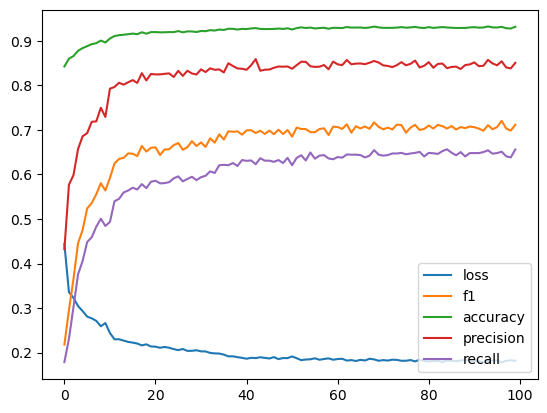

In [28]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['f1'], label='f1')
plt.plot(history.history['accuracy'], label='binary_accuracy')
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['recall'], label='recall')
plt.legend(['loss', 'f1', 'accuracy', 'precision', 'recall'])
plt.savefig("history")

[[1686   38]
 [ 119  157]]


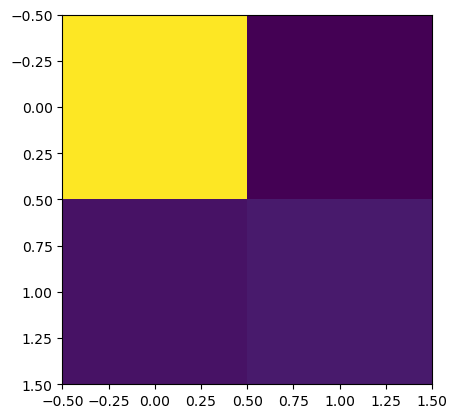

In [40]:
from sklearn.metrics import confusion_matrix
# model.evaluate(train_dataset)
# confusion_prob = model.predict(images[:15000])
# confusion_labels = np.argmax(confusion_prob, axis=1)
confusion_labels = (pred_val1 > 0.5).astype(int)
cm = confusion_matrix(validation_labels, confusion_labels)
print(cm)
plt.imshow(cm)
plt.savefig('cm')
np.savetxt('cm_val', cm)

In [16]:
from sklearn.metrics import f1_score
def f1(labels, predictii):
    predictii = tf.round(predictii)
    return tf.py_function(f1_score, (labels, predictii), tf.float64)
    
model2 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(144, 144, 1)),
    tf.keras.layers.Normalization(mean = 0, variance = 1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(144,144,1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.33),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(2048, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='BinaryCrossentropy',
              metrics=['accuracy', f1])



checkpoint_path = "training_2/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor= 'val_f1',
                                                 save_best_only = True,
                                                 mode = 'max',
                                                 verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 144, 144, 1)       0         
                                                                 
 normalization_4 (Normalizat  (None, 144, 144, 1)      0         
 ion)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 144, 144, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 72, 72, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 72, 72, 32)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 72, 72, 64)       

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
history = model2.fit(train_dataset, validation_data = validation_dataset,
                    epochs=70, callbacks = [callback, cp_callback], batch_size = GLOBAL_BATCH_SIZE, class_weight ={0 : 0.58, 1: 3.35})

Epoch 1/70


2023-04-07 14:22:12.134619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - ETA: 0s - loss: 1.4946 - accuracy: 0.6487 - f1: 0.3575
Epoch 1: val_f1 improved from -inf to 0.26230, saving model to training_2/cp.ckpt
469/469 [==============================] - 42s 73ms/step - loss: 1.4946 - accuracy: 0.6487 - f1: 0.3575 - val_loss: 2.0143 - val_accuracy: 0.2735 - val_f1: 0.2623
Epoch 2/70
469/469 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.6809 - f1: 0.4043
Epoch 2: val_f1 improved from 0.26230 to 0.44975, saving model to training_2/cp.ckpt
469/469 [==============================] - 34s 72ms/step - loss: 0.5684 - accuracy: 0.6809 - f1: 0.4043 - val_loss: 0.3545 - val_accuracy: 0.8555 - val_f1: 0.4497
Epoch 3/70
469/469 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.6933 - f1: 0.4148
Epoch 3: val_f1 did not improve from 0.44975
469/469 [==============================] - 32s 69ms/step - loss: 0.5545 - accuracy: 0.6933 - f1: 0.4148 - val_loss: 0.3471 - val_accuracy: 0.8640 

In [53]:
model2.load_weights('training_2/cp.ckpt')

In [54]:
# PREDICTIA DE LA AL DOILEA MODEL
pred_val2 = model2.predict(images[15000:17000])
print(max(pred_val2))
print(min(pred_val2))
import sklearn, sklearn.metrics
cel_mai_bun_i = -1
cel_mai_bun_f1 = -1
for i in  np.arange(0.000, 1.000, 0.001):
    pred_val_labels = (pred_val2 > i).astype(int)
    f1 = sklearn.metrics.f1_score(validation_labels, pred_val_labels)
    if(f1 >= cel_mai_bun_f1):
        cel_mai_bun_f1 = f1
        cel_mai_bun_i = i
#         print(np.sum(pred_val_labels == 1))
print(cel_mai_bun_i)
print(f"f1 score: {cel_mai_bun_f1}")

63/63 [==============================] - 2s 26ms/step
[0.95819664]
[0.0421606]
0.47300000000000003
f1 score: 0.542728635682159


In [55]:
y = tf.keras.layers.Average()([pred_val1, pred_val2])
print(y)
# y = model.predict(images[15000:17000])
print(max(y))
print(min(y))
import sklearn, sklearn.metrics
cel_mai_bun_i = -1
cel_mai_bun_f1 = -1
for i in  np.arange(0.000, 1.000, 0.001):
#     pred_val_labels = []
#     for j in range(np.shape(pred_val1)[0]):
#         pred_val_labels.append((pred_val1[j] > i and pred_val2[j] > i).astype(int))
    pred_val_labels = (y.numpy() > i).astype(int)
    f1 = sklearn.metrics.f1_score(validation_labels, pred_val_labels)
    if(f1 >= cel_mai_bun_f1):
        cel_mai_bun_f1 = f1
        cel_mai_bun_i = i
#         print(np.sum(pred_val_labels == 1))
print(cel_mai_bun_i)
print(f"f1 score: {cel_mai_bun_f1}")

tf.Tensor(
[[0.02575362]
 [0.3272585 ]
 [0.04261306]
 ...
 [0.02541452]
 [0.77045   ]
 [0.02586214]], shape=(2000, 1), dtype=float32)
tf.Tensor([0.9235341], shape=(1,), dtype=float32)
tf.Tensor([0.02108119], shape=(1,), dtype=float32)
0.41300000000000003
f1 score: 0.6458333333333334


In [70]:
# !mkdir -p saved_model
# model.save('saved_model/my_model')
!zip -r file.zip /kaggle/working/training_1

  adding: kaggle/working/training_1/ (stored 0%)
  adding: kaggle/working/training_1/cp.ckpt.data-00000-of-00001^C



zip error: Interrupted (aborting)


In [8]:
import sklearn
sklearn.utils.class_weight.compute_class_weight('balanced', classes = [0,1], y = labels)

array([0.58768218, 3.35120643])

In [13]:
pred_data_test = model.predict(images[17000:])
print(cel_mai_bun_i)
pred_data_test_labels = (pred_data_test > cel_mai_bun_i).astype(int)
print(np.sum(pred_data_test_labels == 1))
import csv
with open("predictionCnn83_tensorflow_0.665.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "class"])
    for i in range(17000, len(images)):
        writer.writerow(['0' + str(i+1), int(pred_data_test_labels[i - 17000])])

161/161 [==============================] - 3s 17ms/step
0.502
775


In [14]:
pred_data_test_model_1 = model.predict(images[17000:])
# pred_data_test_model_2 = model2.predict(images[17000:])
np.save('pred_test_651_model1', pred_data_test_model_1)
# np.save('pred2', pred_data_test_model_2)


161/161 [==============================] - 2s 15ms/step


In [57]:
np.save("probabilitati1", pred_val1)
np.save("probabilitati2", pred_val2)

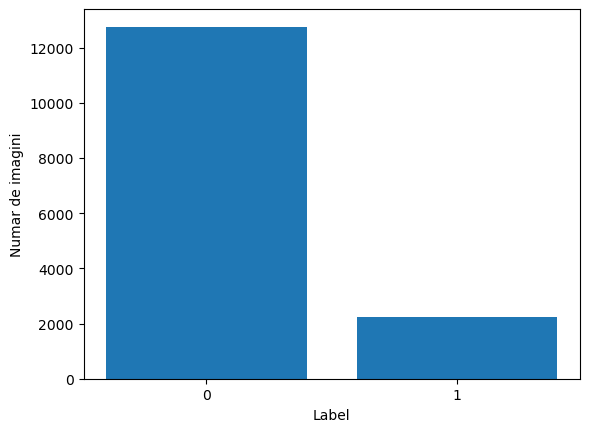

In [128]:
counts = np.bincount(labels)
plt.bar((0,1), counts)
plt.xticks((0,1))
plt.xlabel('Label')
plt.ylabel('Numar de imagini')
# plt.show()
plt.savefig("distributie")

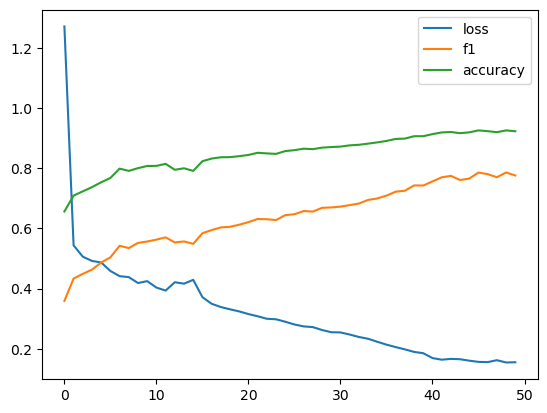

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['f1'], label='f1')
plt.plot(history.history['accuracy'], label='binary_accuracy')
plt.legend(['loss', 'f1', 'accuracy'])
plt.savefig("history")